In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# 1. Dataset Overview

### Let's examine the dataset 
 
In this dataset, each row corresponds to a passenger travelling on the Spaceship Titanic. Sadly, while en route to its first destination, the spaceship Titanic collided with a spacetime anomaly, and some passengers were transported to an alternate dimension. 

In [40]:
df = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

Let's determine how many passengers were transported. 

In [41]:
df['Transported'].mean()

0.5036236051995858

Almost half of the passengers were transported to an alternate dimension!

In [42]:
df['Transported'].value_counts(normalize=True)

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

### Goal of the project

Our goal is to predict which passengers were transported (True) versus those who were not (False) and compare our prediction output (y_pred) with reality (y_true).
The output will be a label: transported (True) or not transported (False), so we are dealing with binary classification. We will use Machine Learning to create our prediction model. Let's gather what we need: split and CatBoost. 

In [43]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool

Our prediction model will use the data features in the dataset to produce the best model prediction. So, let's manage the features.
CatBoost has a unique way of encoding categorical data, so let's group them and remove missing values.

In [44]:
df[['CryoSleep','VIP']] = df[['CryoSleep','VIP']].astype(float)

In [45]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,0.0,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,0.0,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,0.0,A/98/P,55 Cancri e,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,1.0,G/1499/S,PSO J318.5-22,18.0,0.0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,0.0,G/1500/S,TRAPPIST-1e,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,0.0,E/608/S,55 Cancri e,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [46]:
df['CryoSleep'].value_counts()

CryoSleep
0.0    5439
1.0    3037
Name: count, dtype: int64

In [47]:
cat_features = df.select_dtypes(include='object').columns
cat_features

Index(['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Name'], dtype='object')

In [94]:
df[cat_features] = df[cat_features].fillna('no_info')

In [95]:
df[cat_features].isnull().sum()

HomePlanet     0
Cabin          0
Destination    0
dtype: int64

In [51]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,0.0,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,0.0,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,0.0,A/98/P,55 Cancri e,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,1.0,G/1499/S,PSO J318.5-22,18.0,0.0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,0.0,G/1500/S,TRAPPIST-1e,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,0.0,E/608/S,55 Cancri e,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


# 2. Let's build the prediction model! 

### Split the dataset into three parts:
-Train: this will help us train our model to make the best prediction.

-Validation: this will validate our prediction on the unseen portion of the train data.

-Test: this will evaluate our model on an unseen dataset to confirm our model is working well!




In [52]:
train, test = train_test_split(df,test_size=0.2,random_state=42,stratify=df['Transported'])

In [53]:
train_, val = train_test_split(train,test_size=0.25,random_state=42,stratify=train['Transported'])

Let's confirm the data split: 80% for training, 20% for validation, and 20% for testing. 

In [54]:
len(train) / len(df)

0.7999539859657195

In [55]:
len(val) / len(df)

0.20004601403428046

In [56]:
len(test) / len(df)

0.20004601403428046

### Model fit: train and validate

In this first step, we will train our model on the train dataset and evaluate this model on the validation dataset.
Let's define all the columns/features that will be used in this training phase. 


In [57]:
df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [58]:
X = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

cat_features = ['HomePlanet', 'Cabin','Destination']

y = ['Transported']

In [59]:
train_pool_ = Pool(data=train_[X],
                  label=train_[y],
                  cat_features=cat_features
                 )

val_pool = Pool(data=val[X],
                  label=val[y],
                  cat_features=cat_features
                 )
test_data = Pool(data=test[X],
                  label=test[y],
                  cat_features=cat_features
                 )

Now, let's define the parameters to build our Model using the CatBoost classifier algorithm. 

In [60]:
params = {'eval_metric':'AUC',
          'loss_function': 'Logloss',
          'verbose':100,
          'auto_class_weights':'Balanced',
          'learning_rate': 0.020,
          'early_stopping_rounds':200,
          'random_seed':42}

In [61]:
model = CatBoostClassifier(**params)


With the fit command given below, we train our model and evaluate it on the evaluation dataset. We can adjust the learning rate to get the best iteration closer to 999 control the training speed. 

In [62]:
model.fit(train_pool_,eval_set=val_pool)

0:	test: 0.8248940	best: 0.8248940 (0)	total: 66.6ms	remaining: 1m 6s
100:	test: 0.8642181	best: 0.8642181 (100)	total: 1.23s	remaining: 10.9s
200:	test: 0.8695839	best: 0.8695839 (200)	total: 2.41s	remaining: 9.58s
300:	test: 0.8713981	best: 0.8714484 (298)	total: 3.43s	remaining: 7.97s
400:	test: 0.8725238	best: 0.8725238 (400)	total: 4.44s	remaining: 6.63s
500:	test: 0.8731375	best: 0.8733082 (492)	total: 5.51s	remaining: 5.49s
600:	test: 0.8735013	best: 0.8735013 (600)	total: 6.63s	remaining: 4.4s
700:	test: 0.8735509	best: 0.8738413 (683)	total: 7.75s	remaining: 3.31s
800:	test: 0.8734173	best: 0.8738657 (732)	total: 8.85s	remaining: 2.2s
900:	test: 0.8730985	best: 0.8738657 (732)	total: 9.95s	remaining: 1.09s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8738657227
bestIteration = 732

Shrink model to first 733 iterations.


### Results analysis:
We are evaluating the performance of the model at predicting the target variable: Transported passengers. The best test result shows that our model correctly predicts actual transported passengers 82% of the time, indicating a low likelihood of random positives scoring higher than random negatives.

In training and evaluating the model, we obtained two main parameters: the best iteration and the best learning rate, which controls the speed of reaching the overfitting point. 

We will use these two parameters again to train our model on the entire data (Train and Validation) before proceeding to the final evaluation on test data (unseen data).

# 3. Decision step
### Pick the optimal threshold

Let's now examine the scores our model produces, i.e., the probability that each item in the dataset belongs to the positive class. The higher the scores, the higher the probability of correctly predicting the actual transported passengers (y_true). 

In [63]:
val['y_score'] = model.predict_proba(val[X])[:, 1]

In [64]:
val

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,y_score
1226,1304_04,Earth,0.0,E/82/P,TRAPPIST-1e,9.0,0.0,0.0,0.0,0.0,0.0,0.0,Sethew Powenoble,True,0.461605
7719,8235_01,Earth,0.0,F/1576/S,TRAPPIST-1e,15.0,0.0,0.0,21.0,22.0,1149.0,249.0,Joyton Coxterez,False,0.090718
8640,9220_02,Earth,1.0,G/1496/P,TRAPPIST-1e,20.0,0.0,0.0,0.0,0.0,0.0,0.0,Frey Meyerthy,True,0.621406
692,0718_01,Earth,0.0,E/43/P,TRAPPIST-1e,21.0,0.0,521.0,0.0,4.0,261.0,1.0,Alendy Mondsey,False,0.152003
6422,6780_02,Europa,0.0,C/251/S,TRAPPIST-1e,39.0,0.0,2167.0,30.0,1472.0,NaN,0.0,Eltan Plaricit,True,0.273633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,0789_03,Europa,1.0,A/8/S,TRAPPIST-1e,26.0,0.0,0.0,0.0,0.0,0.0,0.0,Zaninon Frolestty,True,0.962668
3146,3392_04,Earth,0.0,G/541/S,TRAPPIST-1e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Coley Gallard,True,0.765661
2089,2234_07,Mars,NaN,F/448/P,TRAPPIST-1e,24.0,0.0,2538.0,0.0,61.0,0.0,0.0,Sumpid Gread,False,0.094952
7384,7894_01,Earth,0.0,E/519/S,55 Cancri e,29.0,0.0,46.0,68.0,589.0,88.0,0.0,Jenne Jacostarks,True,0.425848


How do we determine when the score is high enough to identify all the actual transported passengers (y_true) in the dataset? Let's apply a threshold to the score (y_pred_prob) and determine the level of accuracy in predicting the actual transported passengers (y_true).

In [65]:
from sklearn.metrics import accuracy_score

y_true = val['Transported']
y_pred_probs = val['y_score']

In [66]:
import numpy as np
from sklearn.metrics import accuracy_score

y_true = val['Transported']
y_scores = val['y_score']

# Generate a range of thresholds
thresholds = np.linspace(0, 1, 1000)

# Calculate accuracy for each threshold
accuracies = [accuracy_score(y_true, (y_scores >= threshold).astype(int)) for threshold in thresholds]

# Find the threshold with maximum accuracy
best_threshold = thresholds[np.argmax(accuracies)]
max_accuracy = max(accuracies)

print(f"Best Threshold: {best_threshold}, Max Accuracy: {max_accuracy}")

Best Threshold: 0.6176176176176176, Max Accuracy: 0.7889591719378953


### Results analysis:

We achieved an accuracy of 80% in correctly identifying our target variable of transported passengers (y_true).


# 4. Fit on the whole training data.

Now we are ready to re-train our model on the entire dataset (train and validation data). Let's get everything ready:

- Whole train dataset: including train and validation data.
- Parameters: including best iteration and learning rate previously found.

In [67]:
train_pool = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

In [68]:
model.get_best_iteration()

732

In [69]:
model.get_all_params()['learning_rate']

0.019999999552965164

In [70]:
params = {'iterations': model.get_best_iteration(),
          'learning_rate': model.get_all_params()['learning_rate'],
          'verbose':100,
          'random_seed':42}

In [71]:
model = CatBoostClassifier(**params)

In [72]:
model.fit(train_pool)

0:	learn: 0.6835410	total: 31ms	remaining: 22.6s
100:	learn: 0.4495746	total: 1.44s	remaining: 8.98s
200:	learn: 0.4278569	total: 2.63s	remaining: 6.95s
300:	learn: 0.4183136	total: 3.72s	remaining: 5.33s
400:	learn: 0.4112905	total: 4.86s	remaining: 4.01s
500:	learn: 0.4043667	total: 5.99s	remaining: 2.76s
600:	learn: 0.3964986	total: 7.19s	remaining: 1.57s
700:	learn: 0.3884386	total: 8.37s	remaining: 370ms
731:	learn: 0.3859691	total: 8.76s	remaining: 0us


# 5. Model predictions

### Model evaluation in test data

As last step let's evaluate the performance of our model on test data (unseen data) and its accuracy in making the right predictions.

In [73]:
test_pool = Pool(data=test[X],
                  label=test[y],
                  cat_features=cat_features)

In [74]:
test['y_score'] = model.predict_proba(test[X])[:,1]

To evaluate the performance of our model, we will use the metric: ROC_AUC

In [75]:
from sklearn.metrics import roc_auc_score

In [76]:
roc_auc_score(test['Transported'],test['y_score'])

0.8810120001904793

Let's apply the threshold to obtain the best accuracy on the test data.

In [77]:
test['y_pred'] = (test['y_score'] > best_threshold)

In [78]:
accuracy_score(test['Transported'],test['y_pred'])  

0.7768832662449684

### Results analysis:

We conducted two evaluations so far:

model evaluation on the validation dataset with the best accuracy of 80%

model evaluation on the test dataset with the best accuracy of 80%

Conclusion: our model on unseen data showed a good level of accuracy in making the correct prediction.


# 6. Feature importances and Shap
### Model analysis

Feature importance refers to techniques that calculate a score for all the input features for a given model. The scores represent the “importance” of each feature. A higher score means that the specific feature will have a larger effect on the model that is being used to predict a certain variable.

In [79]:
importances = model.feature_importances_

<Axes: ylabel='Feature Id'>

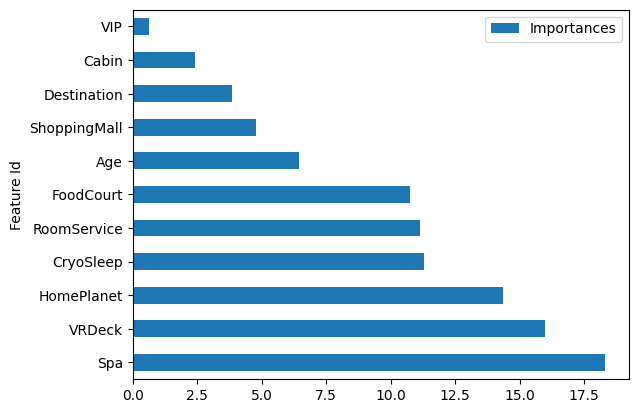

In [80]:
model.get_feature_importance(prettified=True).set_index('Feature Id').plot(kind='barh')

From the graphs above, it is evident that the Spa feature more than other features impacted the model prediction. 

In [81]:
df.groupby('Spa')['Transported'].agg(['count','mean']).sort_values(by = 'mean', ascending = False)

,count,mean
Spa,,
1442.0,1,1.0
1247.0,1,1.0
186.0,1,1.0
1267.0,1,1.0
189.0,1,1.0
...,...,...
785.0,3,0.0
787.0,2,0.0
788.0,4,0.0


Shap on the other end tells us how each feature contributed to the prediction: specifically how a model feature has increased or decreased the prediction power of our model.

In [82]:
import shap

In [83]:
test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,y_score,y_pred
3586,3857_01,Europa,1.0,E/230/P,55 Cancri e,34.0,0.0,0.0,0.0,NaN,0.0,0.0,Eltard Dreamspric,True,0.983919,True
7173,7650_05,Earth,1.0,G/1242/S,TRAPPIST-1e,4.0,0.0,0.0,0.0,0.0,0.0,0.0,Tera Palmes,False,0.661995,True
8559,9139_01,Mars,0.0,F/1766/S,TRAPPIST-1e,25.0,0.0,410.0,32.0,14.0,1239.0,10.0,Poselk Paste,False,0.041705,False
6528,6894_03,Mars,0.0,F/1319/S,TRAPPIST-1e,12.0,NaN,0.0,0.0,0.0,0.0,0.0,Risps Hacle,True,0.821645,True
7934,8471_01,Europa,0.0,E/556/S,55 Cancri e,66.0,1.0,0.0,1828.0,1.0,1873.0,45.0,Bosonon Metiveal,False,0.384644,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3749,4008_01,Mars,1.0,F/760/S,TRAPPIST-1e,33.0,0.0,0.0,0.0,0.0,0.0,0.0,Anamse Cha,True,0.853865,True
1637,1733_01,Earth,0.0,F/344/P,TRAPPIST-1e,15.0,0.0,1336.0,108.0,0.0,0.0,0.0,Stevey Chanan,False,0.162045,False
5820,6158_01,Earth,1.0,G/996/S,PSO J318.5-22,14.0,0.0,0.0,0.0,0.0,0.0,0.0,Dawne Jacobbinson,True,0.707724,True
5757,6102_01,Earth,0.0,F/1165/S,PSO J318.5-22,26.0,0.0,104.0,0.0,0.0,280.0,216.0,Jilley Figuez,False,0.205642,False


In [84]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(test[X])

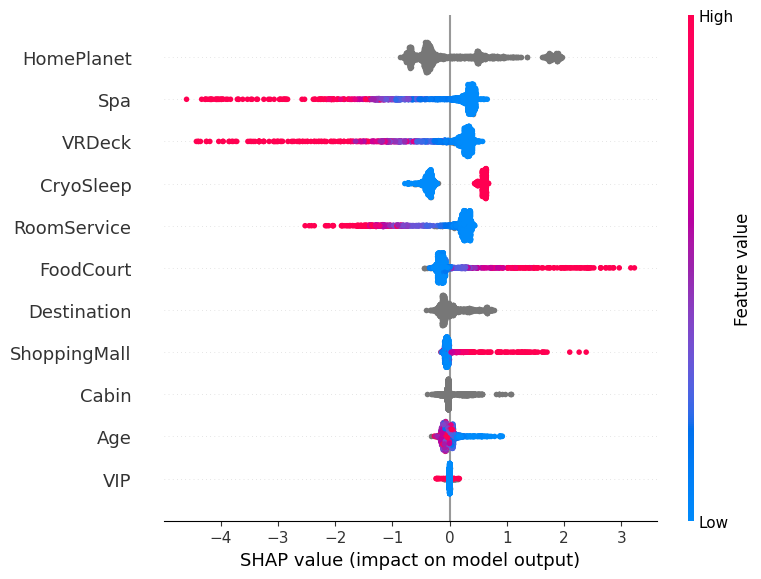

In [85]:
shap.summary_plot(shap_values, test[X])

The shap analysis shows that 'HomePlanet' has the greatest impact on our predictions, followed by 'Spa' and 'VRDeck'in second and third place.

# 7. Kaggle Submission

We are ready for our Kaggle submission!

In [86]:
kaggle_submission = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [87]:
kaggle_submission.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [88]:
kaggle_submission[cat_features]=kaggle_submission[cat_features].fillna('no_info')

In [89]:
kaggle_submission['y_score'] = model.predict_proba(kaggle_submission[X])[:, 1]
kaggle_submission

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,y_score
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0.612018
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0.011291
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0.984082
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,0.897454
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,0.512028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,0.602107
4273,9269_01,Earth,False,no_info,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,0.347345
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,0.943996
4275,9273_01,Europa,False,D/297/P,no_info,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,0.857313


In [90]:
kaggle_submission['Transported']=(kaggle_submission['y_score']>=best_threshold)

In [91]:
kaggle_submission[['PassengerId','Transported']].to_csv('submission.csv', index=False)


In [92]:
kaggle_submission[['PassengerId','Transported']]

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [93]:
kaggle_submission

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,y_score,Transported
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0.612018,False
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0.011291,False
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0.984082,True
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,0.897454,True
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,0.512028,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,0.602107,False
4273,9269_01,Earth,False,no_info,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,0.347345,False
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,0.943996,True
4275,9273_01,Europa,False,D/297/P,no_info,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,0.857313,True


### Leaderborad Score: 0.79120

### Position on leaderboard: 1432 over 2694 submitted competitions

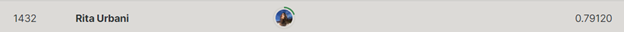

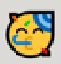